In [ ]:
### --- Feature Extraction Script --- ###
import pandas as pd
import numpy as np
import glob, os
from scipy.stats import kurtosis, skew

data_base = r"c:/TML_Particle_EH5/Project/Project/DataValidation/"
output_path = r"c:/TML_Particle_EH5/Project/Project/ModelWork/features_dataset.csv"

def extract_features(filepath, label):
    df = pd.read_csv(filepath)
    f = {"filename": os.path.basename(filepath), "label": label}

    for col in ['ax', 'ay', 'az']:
        x = df[col]
        f[f"{col}_mean"] = np.mean(x)
        f[f"{col}_std"] = np.std(x)
        f[f"{col}_var"] = np.var(x)
        f[f"{col}_range"] = np.max(x) - np.min(x)
        f[f"{col}_rms"] = np.sqrt(np.mean(x**2))
        f[f"{col}_skew"] = skew(x)
        f[f"{col}_kurtosis"] = kurtosis(x, fisher=False)

    x = df["a_total"]
    f["a_total_energy"] = np.sum(x**2) / len(x)
    f["a_total_max"] = np.max(x)
    f["a_total_min"] = np.min(x)
    f["a_total_median"] = np.median(x)
    # f["a_total_iqr"] = np.percentile(x, 75) - np.percentile(x, 25)
    f["a_total_absmean"] = np.mean(np.abs(x))
    # f["a_total_zero_crossings"] = ((x[:-1] * x[1:]) < 0).sum()
    return f

def load_all_features():
    dataframes = []
    folders = [
        ("Clipped_shots", "shot"),
        ("Clipped_crosses", "cross"),
        ("Clipped_passes", "pass"),
        ("Clipped_noise", "noise")
    ]

    for folder, label in folders:
        path = os.path.join(data_base, folder)
        for f in glob.glob(os.path.join(path, "*.csv")):
            dataframes.append(extract_features(f, label))

    return pd.DataFrame(dataframes)

if __name__ == "__main__":
    df = load_all_features()
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df.to_csv(output_path, index=False)
    print(f"Gemte {len(df)} samples og {df.shape[1]-2} features i {output_path}")


Gemte 296 samples og 26 features i c:/TML_Particle_EH5/Project/Project/ModelWork/features_dataset.csv


In [2]:
### --- Feature Importance and Correlation Analysis --- ###
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import os

input_path = r"c:/TML_Particle_EH5/Project/Project/ModelWork/features_dataset.csv"
output_dir = r"c:/TML_Particle_EH5/Project/Project/ModelWork/"

df = pd.read_csv(input_path)
X = df.drop(columns=["filename", "label"])
y = df["label"]

clf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
clf.fit(X, y)

importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.to_csv(os.path.join(output_dir, "feature_importance.csv"), header=["importance"])

print("\nTop 15 vigtigste features:\n")
print(importances.head(25))

plt.figure(figsize=(10,5))
sns.barplot(x=importances.head(25), y=importances.head(25).index)
plt.title("Feature importance (Top 25)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_importance.png"))
plt.close()

corr = X.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature correlation")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_correlation.png"))
plt.close()

print(f"\nGemte feature_importance.csv, feature_importance.png og feature_correlation.png i {output_dir}")



Top 15 vigtigste features:

ax_skew            0.118913
ax_std             0.077225
ax_var             0.071176
a_total_max        0.066415
ay_range           0.055161
az_skew            0.055022
ay_kurtosis        0.051802
a_total_energy     0.045099
ax_rms             0.042587
az_std             0.035471
az_var             0.035406
ax_kurtosis        0.034891
a_total_absmean    0.032864
a_total_median     0.032036
ay_rms             0.029418
ay_mean            0.028929
ax_mean            0.025674
az_range           0.025450
ay_var             0.025341
ax_range           0.021587
ay_std             0.020569
az_kurtosis        0.016960
az_rms             0.016782
a_total_min        0.014461
ay_skew            0.012055
dtype: float64

Gemte feature_importance.csv, feature_importance.png og feature_correlation.png i c:/TML_Particle_EH5/Project/Project/ModelWork/


In [3]:
### --- Model Training and Evaluation --- ###
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os

input_path = r"c:/TML_Particle_EH5/Project/Project/ModelWork/features_dataset.csv"
model_path = r"c:/TML_Particle_EH5/Project/Project/ModelWork/rf_model.pkl"

df = pd.read_csv(input_path)
X = df.drop(columns=["filename", "label"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=500, class_weight='balanced',max_depth=None ,random_state=42)
clf.fit(X_train, y_train)
# Print out model details (Tree count and max depth)
print(f"Trained Random Forest with {clf.n_estimators} trees and depth {clf.max_depth}")

# Make predictions and evaluate
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=False)
matrix = confusion_matrix(y_test, y_pred)

# Print evaluation results
print("Accuracy:", clf.score(X_test, y_test))
print("\nClassification report:\n", report)
print("Confusion matrix:\n", matrix)

# Save the trained model
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(clf, model_path)
print(f"\nGemte model som {model_path}")



Trained Random Forest with 500 trees and depth None
Accuracy: 0.9166666666666666

Classification report:
               precision    recall  f1-score   support

       cross       0.93      0.93      0.93        15
       noise       0.83      1.00      0.91        15
        pass       1.00      1.00      1.00        16
        shot       0.91      0.71      0.80        14

    accuracy                           0.92        60
   macro avg       0.92      0.91      0.91        60
weighted avg       0.92      0.92      0.91        60

Confusion matrix:
 [[14  0  0  1]
 [ 0 15  0  0]
 [ 0  0 16  0]
 [ 1  3  0 10]]

Gemte model som c:/TML_Particle_EH5/Project/Project/ModelWork/rf_model.pkl


Best model:
  n_estimators = 200
  max_depth    = 9
  F1 score     = 0.9302


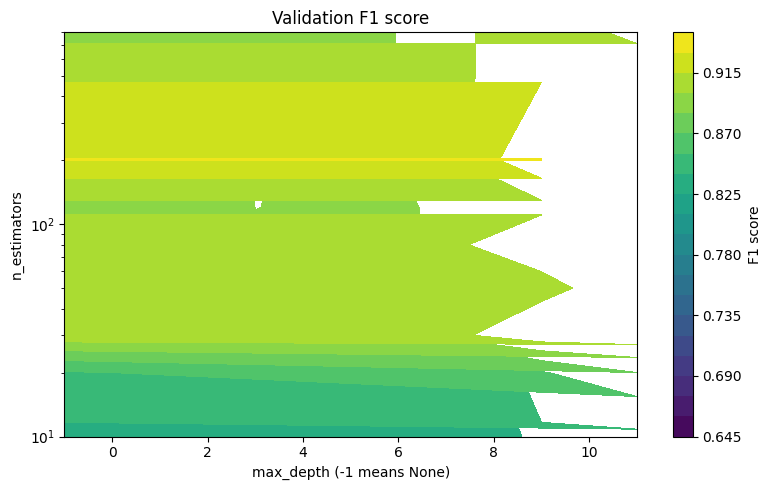

In [ ]:
### --- Hyperparameter Optimization --- ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Load your dataset
path = r"c:/TML_Particle_EH5/Project/Project/ModelWork/features_dataset.csv"
df = pd.read_csv(path)

X = df.drop(columns=["filename", "label"])
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Hyperparameter grid
depths = [2, 3, 5, 7, 9, 11, None, None, None]
trees  = [10, 20, 30, 50, 80, 120, 200, 500, 800]

train_scores = np.zeros((len(trees), len(depths)))
test_scores  = np.zeros((len(trees), len(depths)))

# Grid search (manual, full control)
for ti, n_tree in enumerate(trees):
    for di, depth in enumerate(depths):

        clf = RandomForestClassifier(
            n_estimators=n_tree,
            max_depth=depth,
            random_state=42,
        )

        clf.fit(X_train, y_train)

        y_train_pred = clf.predict(X_train)
        y_test_pred  = clf.predict(X_test)

        train_scores[ti, di] = f1_score(y_train, y_train_pred, average="macro")
        test_scores[ti, di]  = f1_score(y_test,  y_test_pred,  average="macro")


# Find best parameters
idx = np.unravel_index(np.argmax(test_scores), test_scores.shape)
best_trees = trees[idx[0]]
best_depth = depths[idx[1]]
best_f1    = test_scores[idx]

print("Best model:")
print(f"  n_estimators = {best_trees}")
print(f"  max_depth    = {best_depth}")
print(f"  F1 score     = {best_f1:.4f}")

# Plot heatmap for visual overview
D, T = np.meshgrid(
    [d if d is not None else -1 for d in depths],
    trees
)

plt.figure(figsize=(8,5))
cp = plt.contourf(D, T, test_scores, levels=25)
plt.colorbar(cp, label="F1 score")
plt.xlabel("max_depth (-1 means None)")
plt.ylabel("n_estimators")
plt.title("Validation F1 score")
plt.yscale("log")
plt.tight_layout()
plt.show()

#


In [5]:
### --- Model Training with Optimized Parameters --- ###
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os

input_path = r"c:/TML_Particle_EH5/Project/Project/ModelWork/features_dataset.csv"
model_path = r"c:/TML_Particle_EH5/Project/Project/ModelWork/rf_model_optimized.pkl"

df = pd.read_csv(input_path)
X = df.drop(columns=["filename", "label"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=200, max_depth=9, random_state=42)
clf.fit(X_train, y_train)
# Print out model details (Tree count and max depth)
print(f"Trained Random Forest with {clf.n_estimators} trees and depth {clf.max_depth}")

# Make predictions and evaluate
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=False)
matrix = confusion_matrix(y_test, y_pred)

# Print evaluation results
print("Accuracy:", clf.score(X_test, y_test))
print("\nClassification report:\n", report)
print("Confusion matrix:\n", matrix)

# Save the trained model
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(clf, model_path)
print(f"\nGemte model som {model_path}")




Trained Random Forest with 200 trees and depth 9
Accuracy: 0.9333333333333333

Classification report:
               precision    recall  f1-score   support

       cross       1.00      0.93      0.97        15
       noise       0.83      1.00      0.91        15
        pass       1.00      1.00      1.00        16
        shot       0.92      0.79      0.85        14

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

Confusion matrix:
 [[14  0  0  1]
 [ 0 15  0  0]
 [ 0  0 16  0]
 [ 0  3  0 11]]

Gemte model som c:/TML_Particle_EH5/Project/Project/ModelWork/rf_model_optimized.pkl


In [22]:
import emlearn
import joblib

# Load model path
model_path = r"c:/TML_Particle_EH5/Project/Project/ModelWork/rf_model_optimized.pkl"

model = joblib.load(model_path)
print("model Loaded.")

# Convert to embedded C with emlearn
cmodel = emlearn.convert(model)
print("Model converted to embedded C.")

# Save model as C header file
OUTPUT_FILE = "rf_model_eml.h"
MODEL_NAME = "rf_kick_model"

cmodel.save(
    file=OUTPUT_FILE,
    name=MODEL_NAME
)

print(f"Emlearn-model saved as: {OUTPUT_FILE}, with path: {os.path.abspath(OUTPUT_FILE)}")

model Loaded.
Model converted to embedded C.
Emlearn-model saved as: rf_model_eml.h, with path: c:\TML_Particle_EH5\Project\Project\ModelWork\rf_model_eml.h


In [23]:
df = pd.read_csv("features_dataset.csv")
print(sorted(df["label"].unique()))


['cross', 'noise', 'pass', 'shot']
